In [1]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=cb7ba856e29d2b3f155edebc2ea21dc2c659258ffec29d8545738dd3f5d840c5
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [2]:
!pip install spectral

In [3]:
!pip install keras

In [4]:
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import math

init_notebook_mode(connected=True)
%matplotlib inline


2024-05-06 21:17:23.538966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 21:17:23.539064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 21:17:23.693383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
if not (os.path.isfile('Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

--2024-05-06 21:21:27--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2024-05-06 21:21:28--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: 'Indian_pines_corrected.mat'

Indian_pines_correc 100%[===================>]   5.68M  1.19MB/s    in 4.8s    

2024-05-06 21:21:34 (1.19 MB/s) - 'Indian_pines_corrected.mat' saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2024-05-06 21:21:35--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.e

# Data Loading

In [5]:
## GLOBAL VARIABLES
test_ratio = 0.7
windowSize = 25

Indian Pines is a Hyperspectral image segmentation dataset. The input data consists of hyperspectral bands over a single landscape in Indiana, US, (Indian Pines data set) with 145×145 pixels. For each pixel, the data set contains 200 spectral reflectance bands which represent different portions of the electromagnetic spectrum in the wavelength range 0.4−2.5⋅10−6.

In [10]:
def loadData():
    data_path = os.path.join(os.getcwd(),'')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']

    return data, labels

# Understanding the data

In [11]:
X, y = loadData()# x: data, y:labels

X.shape, y.shape

((145, 145, 200), (145, 145))

The shape (145, 145, 200) represents a three-dimensional array. Each dimension has a specific interpretation:

1-First Dimension (Height): The first dimension with size 145 represents the height of the image. This dimension corresponds to the number of rows in the image. \
2-Second Dimension (Width): The second dimension with size 145 represents the width of the image. This dimension corresponds to the number of columns in the image.\
3-Third Dimension (Channels or Bands): The third dimension with size 200 represents the number of channels or bands in the image. In the context of hyperspectral imaging, each channel or band typically represents a different wavelength of light reflected from the scene. Therefore, in a hyperspectral image, each pixel has a reflectance value for each of the 200 spectral bands.

So, in summary, the shape (145, 145, 200) indicates that you have a hyperspectral image with dimensions 145x145 pixels and 200 spectral bands or channels. Each pixel in the image has a reflectance value for each of the 200 spectral bands.

In [80]:
print(X)

[[[3172 4142 4506 ... 1057 1020 1020]
  [2580 4266 4502 ... 1064 1029 1020]
  [3687 4266 4421 ... 1061 1030 1016]
  ...
  [2570 3890 4320 ... 1042 1021 1015]
  [3170 4130 4320 ... 1054 1024 1020]
  [3172 3890 4316 ... 1043 1034 1016]]

 [[2576 4388 4334 ... 1047 1030 1006]
  [2747 4264 4592 ... 1055 1039 1015]
  [2750 4268 4423 ... 1047 1026 1015]
  ...
  [3859 4512 4605 ... 1056 1035 1015]
  [3686 4264 4690 ... 1051 1012 1020]
  [2744 4268 4597 ... 1047 1019 1016]]

 [[2744 4146 4416 ... 1055 1029 1025]
  [2576 4389 4416 ... 1051 1021 1011]
  [2744 4273 4420 ... 1068 1033 1010]
  ...
  [2570 4266 4509 ... 1051 1025 1010]
  [2576 4262 4496 ... 1047 1029 1020]
  [2742 4142 4230 ... 1042 1025 1011]]

 ...

 [[3324 3728 4002 ... 1003 1004 1004]
  [2983 3604 3829 ... 1011 1013 1008]
  [2988 3612 3913 ... 1012 1001 1004]
  ...
  [2564 4115 4103 ... 1003 1005 1013]
  [2730 4111 4103 ... 1015 1013 1004]
  [3156 3991 4103 ... 1017 1014 1000]]

 [[3161 3731 3834 ... 1002 1000 1000]
  [2727 3742

Each number represents the reflectance intensity of a pixel at a specific location in the image. The three-dimensional array contains the reflectance values for all pixels across all spectral bands.

For instance, 3172 is the reflectance intensity of a pixel at the first spectral band, 4142 is the reflectance intensity at the second spectral band, 4506 is the reflectance intensity at the third spectral band, and so on, until the last spectral band represented by 1016.

So, each value in the array corresponds to the reflectance intensity of a pixel at a specific location and spectral band within the hyperspectral image.

In [81]:
print(y)

[[3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [82]:
unique_classes = np.unique(y)

print("Unique Classes:", unique_classes)

Unique Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Each number represents a class or category. For instance, 3 may represent one type of land cover or land use class, 0 may represent another type of land cover or land use class, and so on.

The array y contains the labels or classes assigned to each pixel in the corresponding hyperspectral image X. These labels are often used for tasks such as classification or segmentation, where the goal is to assign each pixel to a specific category or class based on its spectral characteristics.

In [12]:
#reshipe the  into a two-dimensional array
# each row represents a pixel and each column represents a spectral band

import pandas as pd
data=X

# Reshapes the data array into a 2D array with the first dimension being the total number of pixels
#(product of the first two dimensions of data) and the second dimension being inferred (-1) based on the original shape.
data_df = pd.DataFrame(data.reshape(data.shape[0] * data.shape[1], -1))
data_df.columns = [f'band{i}' for i in range(1, data_df.shape[-1] + 1)]

# Flatten the y array to match the shape of data_df
y_flat = y.flatten()

# Add a new column named 'class' to data_df and assign the values from y_flat
data_df['class'] = y_flat

data_df.shape
data_df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In remote sensing, each "band" refers to a specific range of wavelengths of electromagnetic radiation captured by a sensor. These bands correspond to different regions of the electromagnetic spectrum and are used to gather information about the Earth's surface.

The specific interpretation of each band depends on the sensor used to capture the data and the application of the remote sensing analysis. However, in general:

Band 1, Band 2, ..., Band N: Each band represents the intensity of radiation measured within a particular wavelength range. These values can provide information about the properties of the surface being observed, such as vegetation health, soil moisture, urban development, and more.

In this case band1, band2, ..., band200 represent the pixel values for each spectral band in the dataset, with each row corresponding to a pixel in the image. These values capture the intensity of electromagnetic radiation measured by the sensor across the different wavelengths or bands.

In [84]:
def visualize_hyperspectral_image_channels(X, grid_width=5):
    #num_channels = X.shape[2]
    num_channels = 12
    grid_height = math.ceil(num_channels / grid_width)

    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 4 * grid_height))
    fig.subplots_adjust(hspace=0.5)

    for i in range(num_channels):
        ax = axs[i // grid_width, i % grid_width]
        ax.imshow(X[:, :, i])
        ax.set_title(f'Channel {i}')
        ax.axis('off')

    plt.show()

def visualize_labels(labels):
    plt.figure(figsize=(10, 5))
    plt.imshow(labels)
    plt.title('Ground Truth Labels')
    plt.colorbar()
    plt.show()

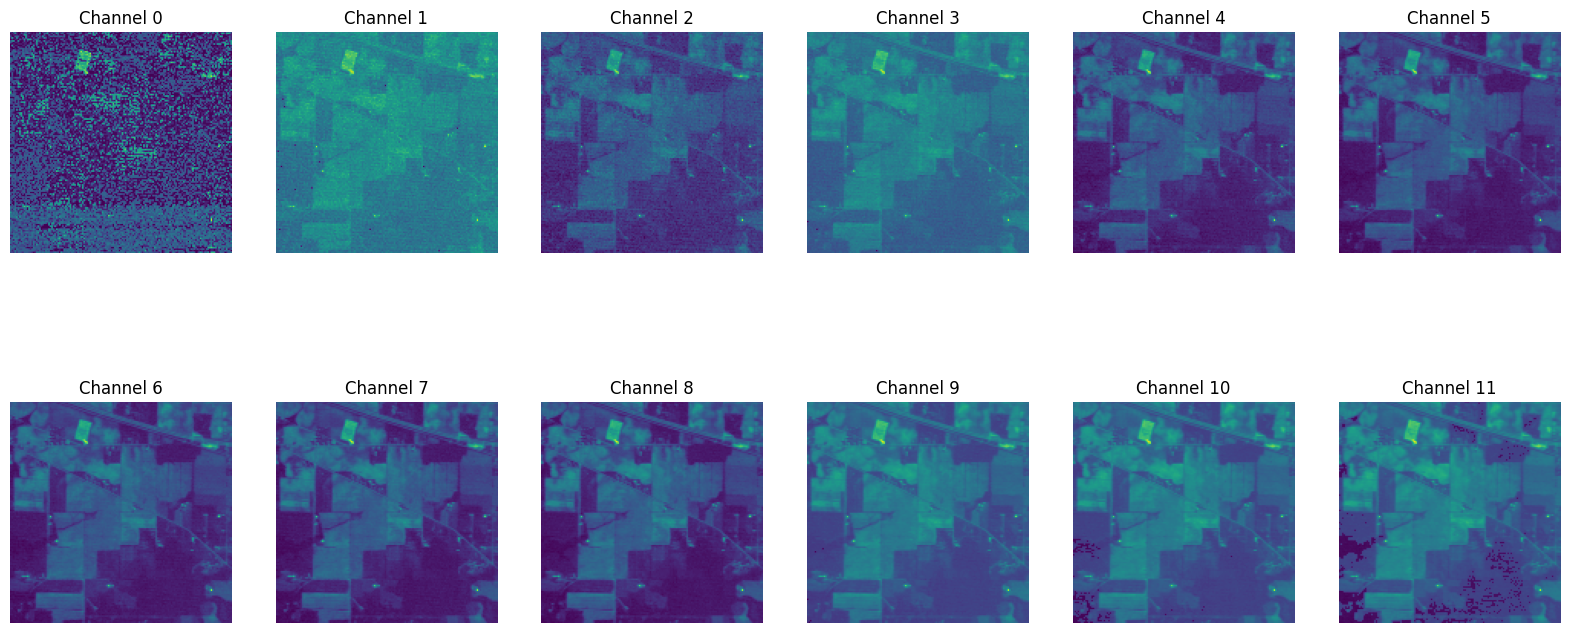

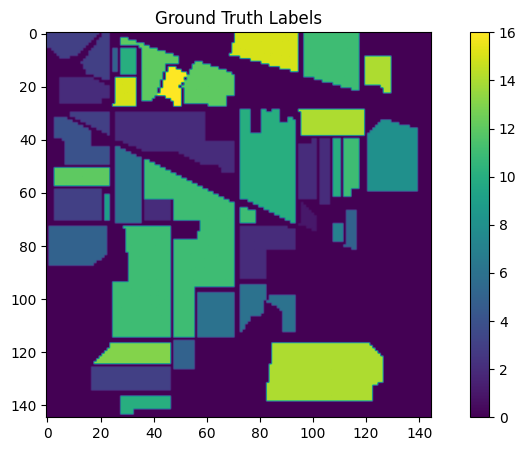

In [85]:
# Visualize all channels of the hyperspectral image
visualize_hyperspectral_image_channels(X, grid_width=6)

# Visualize ground truth labels
visualize_labels(y)

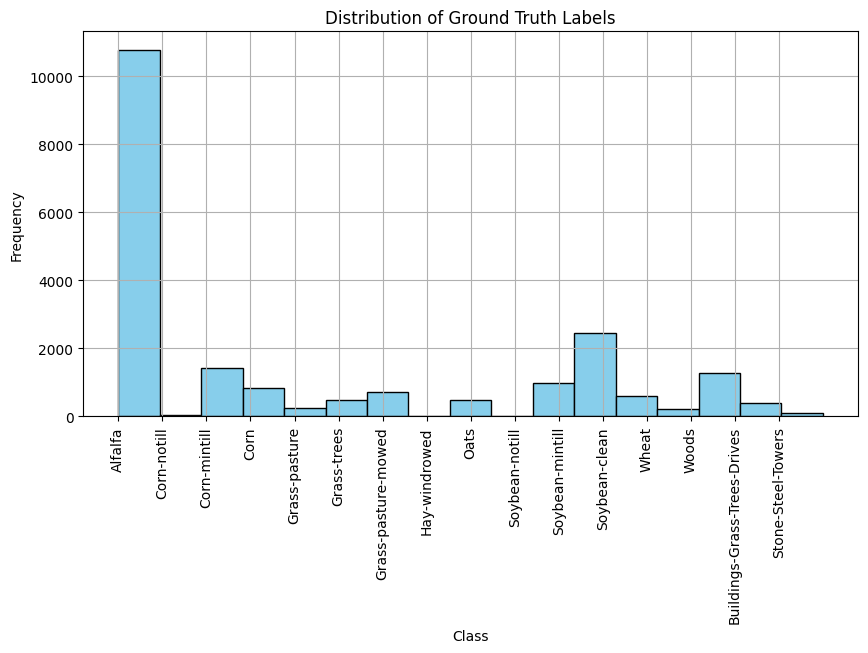

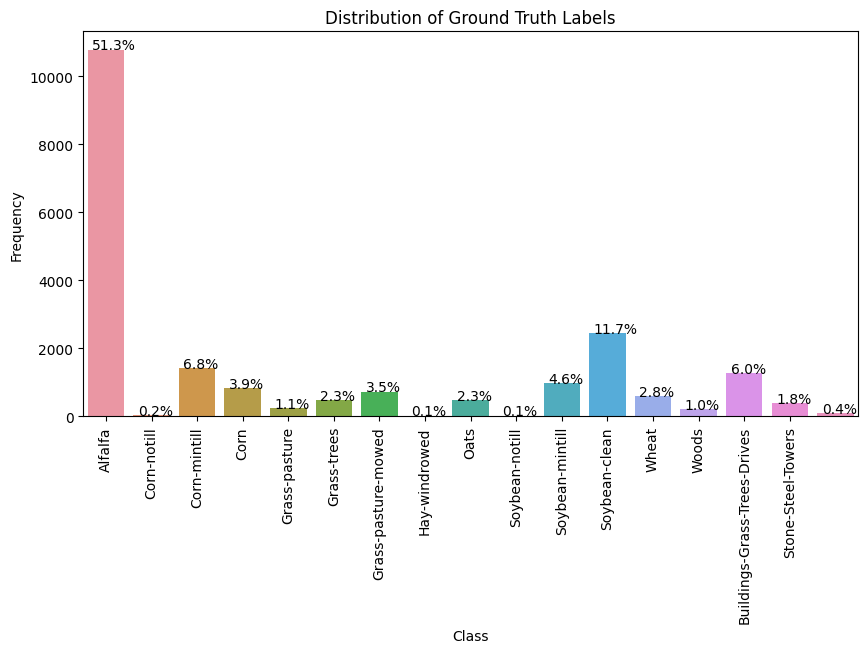

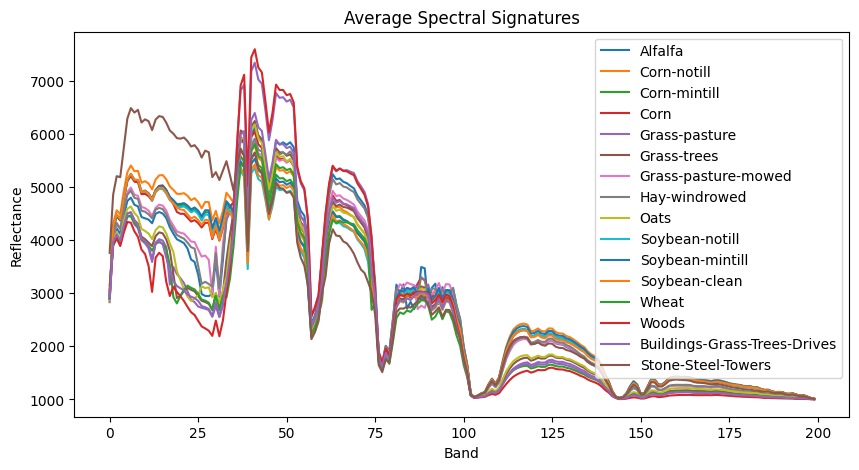

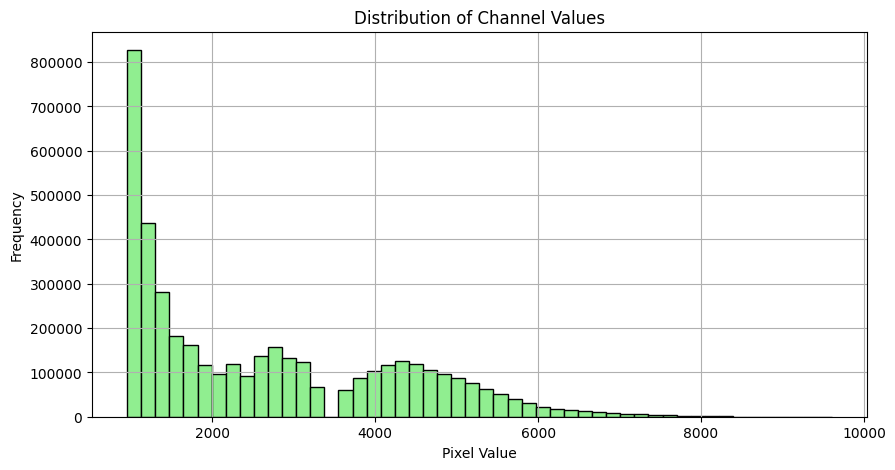

In [15]:
import seaborn as sns
data=X
labels=y
# Define the class names
class_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn',
               'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
               'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

# Create a mapping dictionary from class numbers to class names
class_mapping = {i: class_names[i] for i in range(len(class_names))}

# Flatten the labels to 1D array for histogram
labels_flat = labels.flatten()

# Plot histogram of ground truth labels
plt.figure(figsize=(10, 5))
plt.hist(labels_flat, bins=len(np.unique(labels_flat)), color='skyblue', edgecolor='black')
plt.title('Distribution of Ground Truth Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(len(class_names)), [class_mapping[i] for i in range(len(class_names))], rotation=90)
plt.grid(True)
plt.show()



# Plot distribution of ground truth labels in %
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='class', data=data_df[['class']])
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/data_df.shape[0]), (p.get_x()+0.1, p.get_height()+5))
#ax.yaxis.set_major_locator(ticker.LinearLocator(11))
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.xticks(range(len(class_names)), [class_mapping[i] for i in range(len(class_names))], rotation=90)
plt.title('Distribution of Ground Truth Labels')
plt.show()



# Plot spectral signatures
spectral_signatures = []
for cls in range(1, 17):
    class_df = data_df[data_df['class'] == cls]
    # Calculate average spectral signature across all pixels in the class
    avg_spectrum = class_df.drop(columns=['class']).mean(axis=0)
    spectral_signatures.append(avg_spectrum)

plt.figure(figsize=(10, 5))
for i, spectrum in enumerate(spectral_signatures):
    plt.plot(spectrum.values, label=class_names[i])
    
plt.title('Average Spectral Signatures')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.legend()
plt.show()



# Plot histogram of channel values
plt.figure(figsize=(10, 5))
plt.hist(data.flatten(), bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Channel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

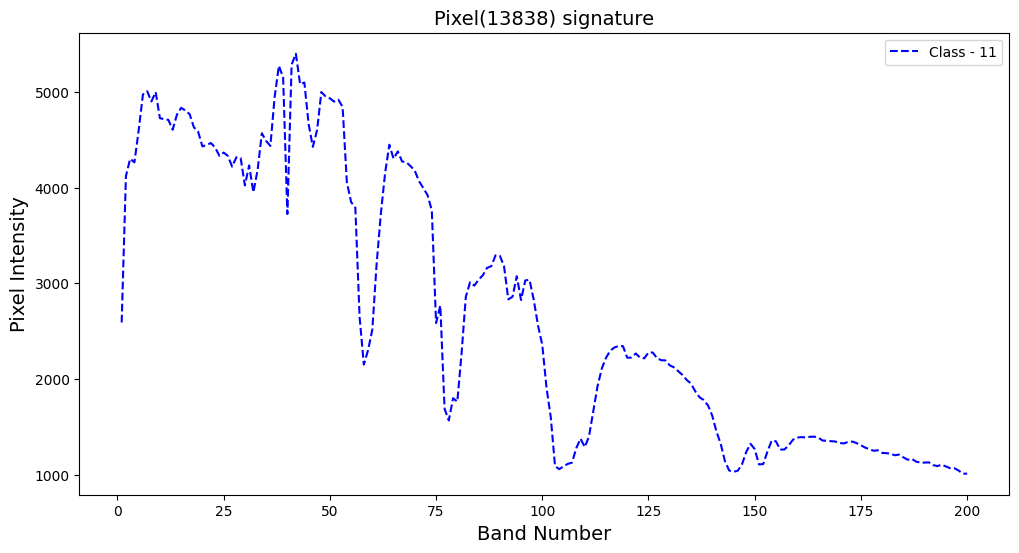

In [87]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 201), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()
     
plot_signature(data_df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

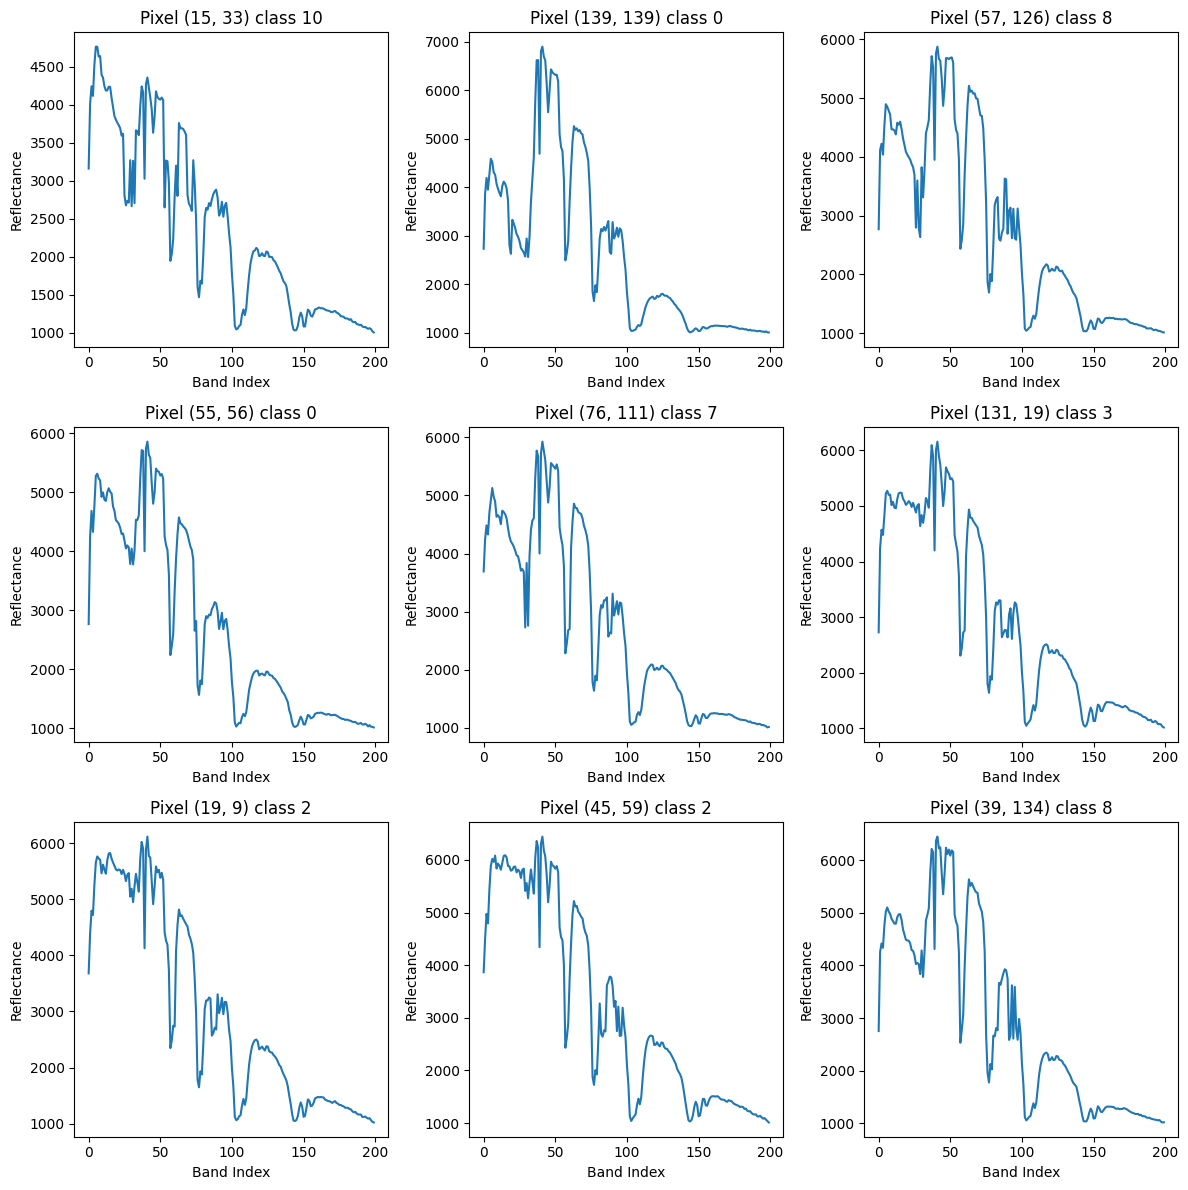

In [25]:
np.random.seed(35)

# Generate 9 random pixel coordinates
random_pixels = np.random.randint(0, 145, size=(9, 2))

# Plot spectral profiles for each random pixel
mdata = np.moveaxis(X, -1, 0)
plt.figure(figsize=(12, 12))
for i, (x_pixel, y_pixel) in enumerate(random_pixels, 1):
    # Extract spectral profile for the current pixel
    spectral_profile = mdata[:, x_pixel, y_pixel]
    
    # Check if spectral profile contains only zero or near-zero values
    if np.allclose(spectral_profile, 0):
        # Skip this pixel and continue to the next one
        continue
    
    # Plot spectral profile in a 3x3 grid
    plt.subplot(3, 3, i)
    sns.lineplot(x=np.arange(len(spectral_profile)), y=spectral_profile)
    plt.title(f'Pixel ({x_pixel}, {y_pixel}) class {y[x_pixel, y_pixel]}')
    plt.xlabel('Band Index')
    plt.ylabel('Reflectance')

plt.tight_layout()
plt.show()

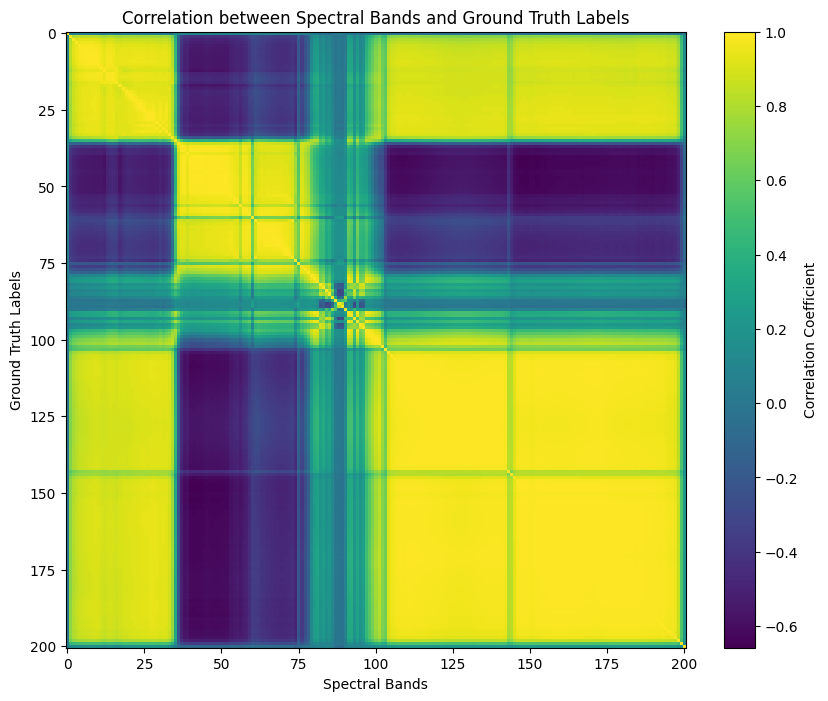

In [88]:
# Reshape X to have one row per pixel and one column per spectral band
X_reshaped = X.reshape(-1, X.shape[2])

# Compute correlation coefficients between bands and ground truth labels
correlation_matrix = np.corrcoef(X_reshaped.T, y.flatten())

# Plot correlation coefficients
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation between Spectral Bands and Ground Truth Labels')
plt.xlabel('Spectral Bands')
plt.ylabel('Ground Truth Labels')
plt.show()


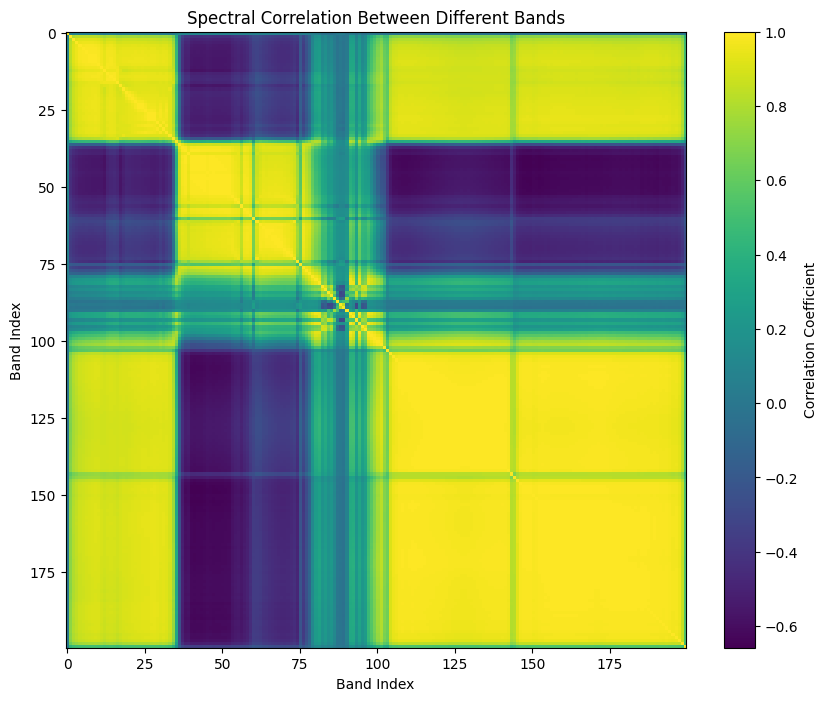

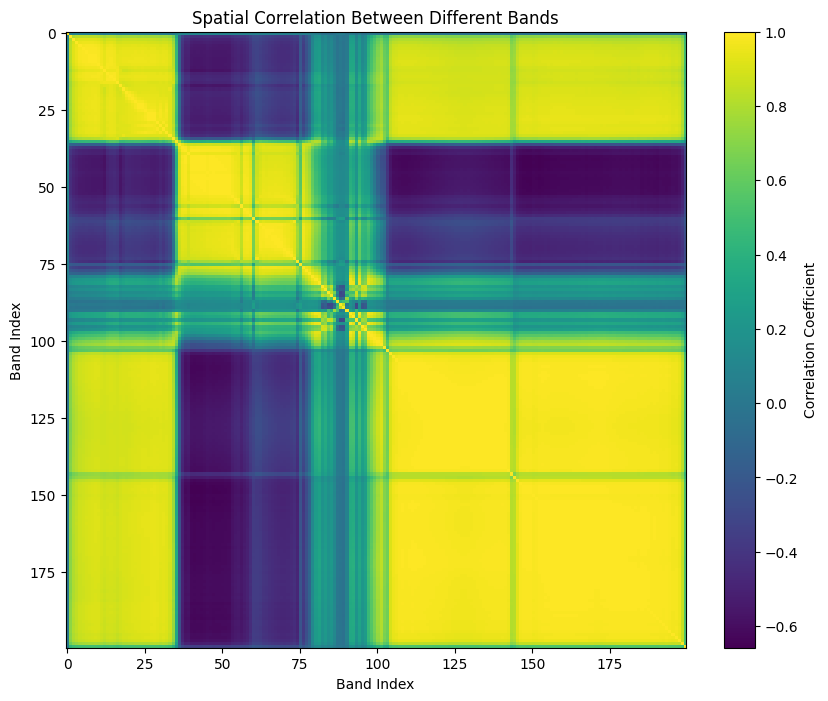

In [89]:
# Calculate the correlation matrix for spectral bands
spectral_corr = np.corrcoef(data.reshape(-1, data.shape[2]), rowvar=False)

# Plot the spectral correlation heatmap
plt.figure(figsize=(10, 8))
plt.imshow(spectral_corr, cmap='viridis', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Spectral Correlation Between Different Bands')
plt.xlabel('Band Index')
plt.ylabel('Band Index')
plt.show()

# Calculate the correlation matrix for spatial bands (e.g., across pixels)
spatial_corr = np.corrcoef(data.reshape(data.shape[0] * data.shape[1], data.shape[2]), rowvar=False)

# Plot the spatial correlation heatmap
plt.figure(figsize=(10, 8))
plt.imshow(spatial_corr, cmap='viridis', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Spatial Correlation Between Different Bands')
plt.xlabel('Band Index')
plt.ylabel('Band Index')
plt.show()


# Preprocessing

**Dimension Reduction functions**

In [23]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

**Principal Component Analysis (PCA)** is a widely used dimensionality reduction technique that aims to transform high-dimensional data into a lower-dimensional space while preserving most of the important information. The core idea behind PCA is to find a new set of variables (called principal components) that are linear combinations of the original variables and capture the maximum variance in the data.

**Factor Analysis (FA)** is a statistical method used to identify underlying latent variables (factors) that explain patterns of correlations among observed variables. It is commonly used in fields such as psychology, sociology, economics, and market research to understand the structure of complex data sets and reduce the dimensionality of data.

In [19]:
import spectral
from sklearn.decomposition import FactorAnalysis, NMF
from sklearn.decomposition import PCA, TruncatedSVD
# Dimensionality reduction algorithms

def applyPCA(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    pca = PCA(n_components=numComponents, whiten=True, random_state=random_state)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def applyFA(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    fa = FactorAnalysis(n_components=numComponents, random_state=random_state)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa

def applySVD(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    svd = TruncatedSVD(n_components=numComponents, random_state=random_state)
    newX = svd.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, svd

def applyNMF(X, numComponents=75, random_state=0):
    newX = np.reshape(X, (-1, X.shape[2])) # Reshape to columns for each band
    nmf = NMF(n_components=numComponents, random_state=random_state)
    newX = nmf.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, nmf

def applyNone(X, numComponents=75, random_state=0):
    return X, 'None'

In [16]:
def plot_sc(X, max_components=None):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA()
    pca.fit(newX)
    ev = pca.explained_variance_ratio_

    if max_components is None:
        max_components = len(ev)

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, max_components + 1), ev.cumsum()[:max_components], marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Plot')
    for i in range(0, len(ev.cumsum()), 10):
        plt.text(i, ev.cumsum()[i], f'{ev.cumsum()[i]:.4f}', ha='right', va='bottom')
    plt.grid(True)
    plt.show()

    return pca

In [20]:
def plot_f(X, max_components=None):
    newX = np.reshape(X, (-1, X.shape[2]))
    fap = FactorAnalysis()
    fap.fit(newX)

    # Compute the eigenvalues of the factor loadings matrix
    eigenvalues = np.linalg.eigvals(fap.components_.T @ fap.components_)

    # Compute the explained variance ratio
    ev = eigenvalues / np.sum(eigenvalues)

    if max_components is None:
        max_components = len(ev)

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, max_components + 1), ev.cumsum()[:max_components], marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Factor Analysis Plot')
    for i in range(0, len(ev.cumsum()), 10):
        plt.text(i, ev.cumsum()[i], f'{ev.cumsum()[i]:.4f}', ha='right', va='bottom')
    plt.grid(True)
    plt.show()

    return fap

In [24]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [25]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

The function createImageCubes takes an input hyperspectral image X and its corresponding labels y, along with parameters specifying the window size for creating image cubes (windowSize) and whether to remove patches with zero labels (removeZeroLabels).

Here's how the function works:

**Padding with Zeros:** The input image X is padded with zeros around its edges to accommodate the window size. This padding ensures that patches near the image borders can still be extracted without running out of bounds.\
**Looping through Patches**: The function then loops through each pixel position (r, c) in the zero-padded image zeroPaddedX. At each position, a patch of size windowSize x windowSize is extracted centered around the current pixel.\
**Extracting Patches:** For each pixel position (r, c), a window of size windowSize x windowSize is extracted from the zero-padded image. This window forms a patch of the original hyperspectral image. The patch, along with its corresponding label from y, is stored in the patchesData and patchesLabels arrays, respectively.\
**Removing Zero Labels (Optional):** If the removeZeroLabels parameter is set to True, patches with zero labels are removed from the patchesData and patchesLabels arrays. This step is often necessary to exclude background patches with no meaningful information.\
**Returning Patches:** Finally, the function returns the extracted patches (patchesData) and their corresponding labels (patchesLabels). These patches are essentially the input data and labels for training a machine learning model, such as a convolutional neural network (CNN), for tasks like classification or segmentation on hyperspectral images.

In [17]:
K = X.shape[2]
print(K)

200


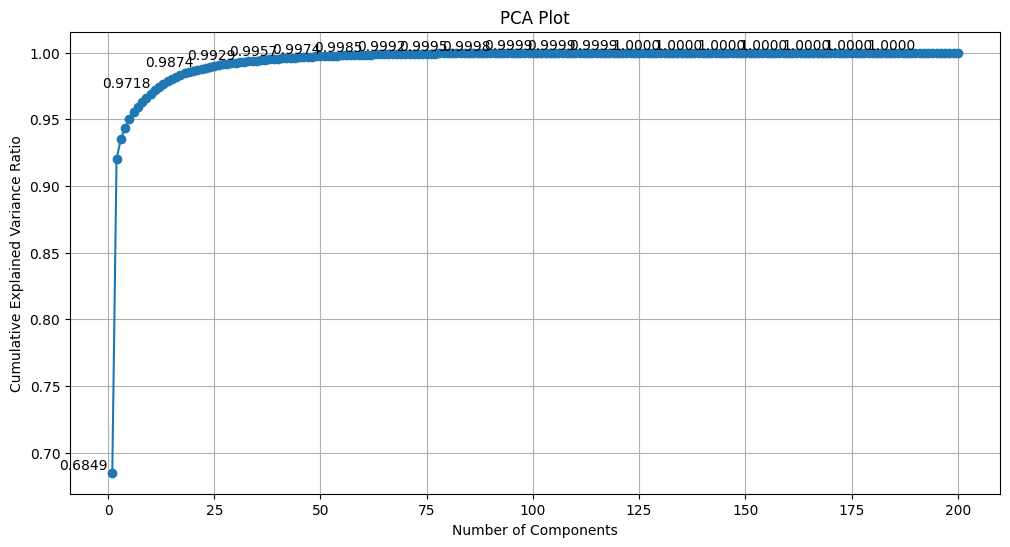

PCA()

In [18]:
plot_sc(X)

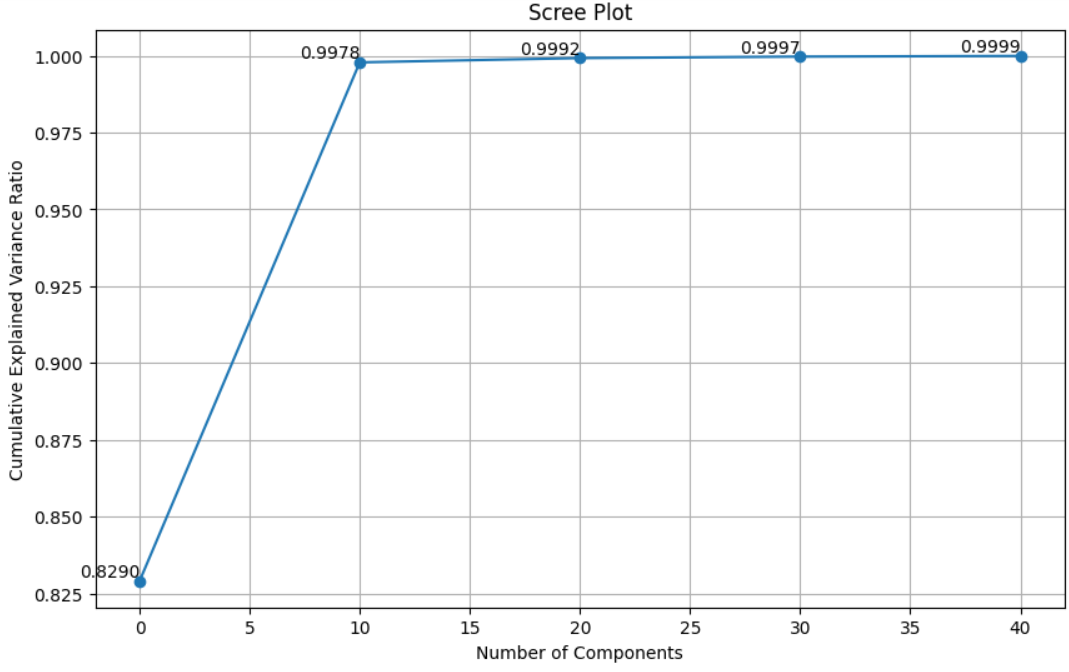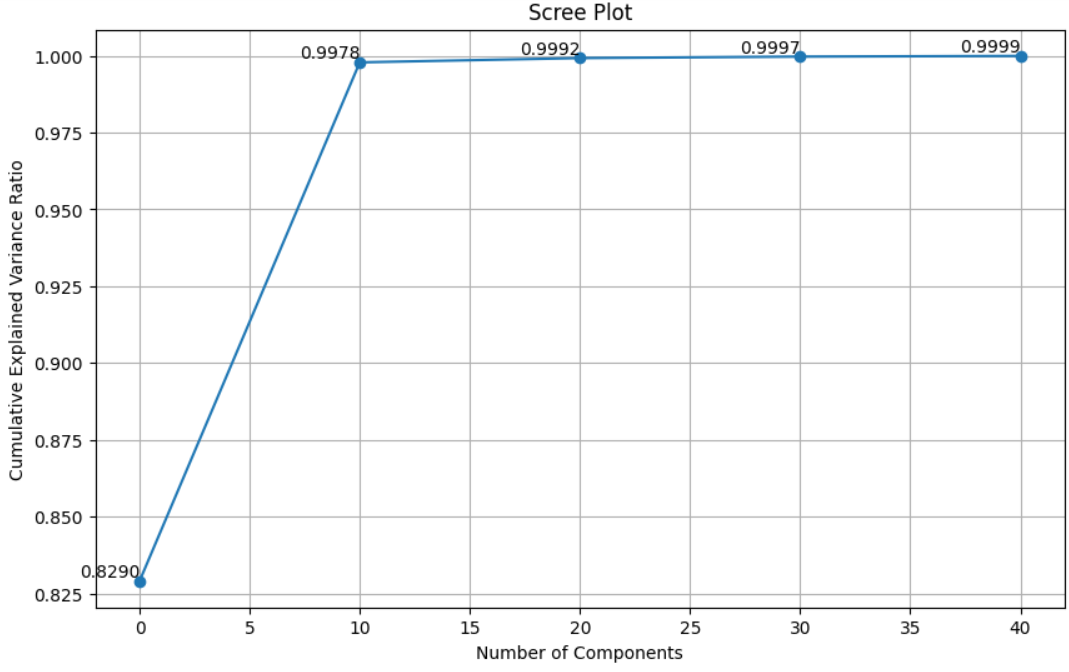

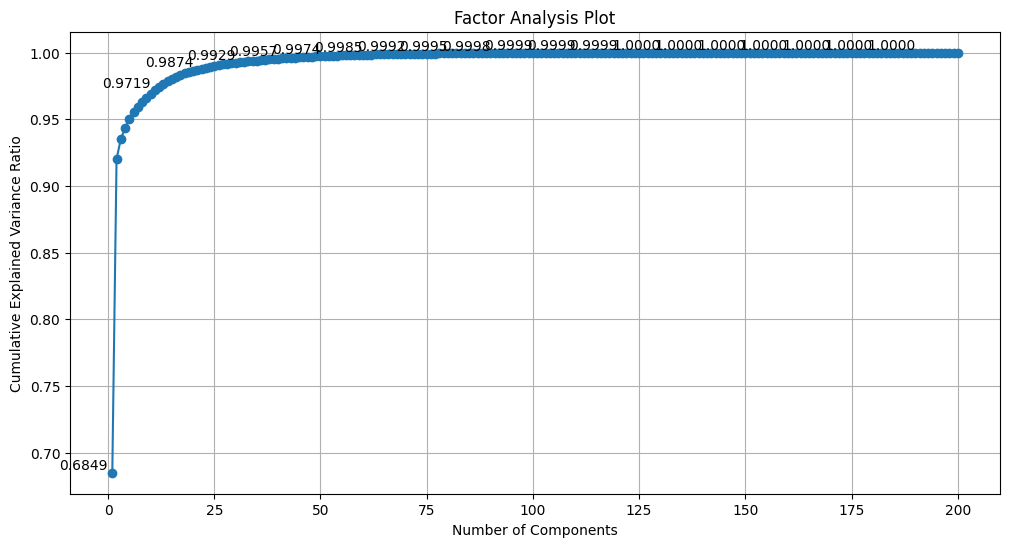

FactorAnalysis()

In [21]:
plot_f(X)

In [26]:
K = 30
X,pca = applyPCA(X,numComponents=K)
X.shape, y.shape

((145, 145, 30), (145, 145))

**Non-Local Means Denoising Filter**

The NLM filter works by averaging similar patches of pixels in an image to reduce noise. Unlike local filters that only consider nearby pixels, NLM compares patches from different parts of the image.\
For each pixel in the image, the filter calculates a weighted average of all pixels in the image, where the weights are determined by the similarity between the patch centered at the pixel of interest and patches centered at all other pixels.\
By incorporating information from distant patches, the NLM filter can effectively remove noise while preserving fine image details.

estimate_sigma() function: The function estimates the standard deviation of the noise present in the image. It does so by assuming that the image contains Gaussian-distributed noise.
It calculates the standard deviation of the noise separately for each channel (e.g., RGB channels in a color image).
The estimated sigma value represents an approximation of the noise level in the image.

In [99]:
from skimage import img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma

# Assuming `X` is your noisy hyperspectral data
noisy = img_as_float(X)
# Estimate the noise standard deviation
sigma_est = np.mean(estimate_sigma(noisy, channel_axis=-1))

patch_kw = dict(
    patch_size=25, patch_distance=35, channel_axis=-1  # 5x5 patches
)
# Apply non-local means denoising
denoised = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=True)

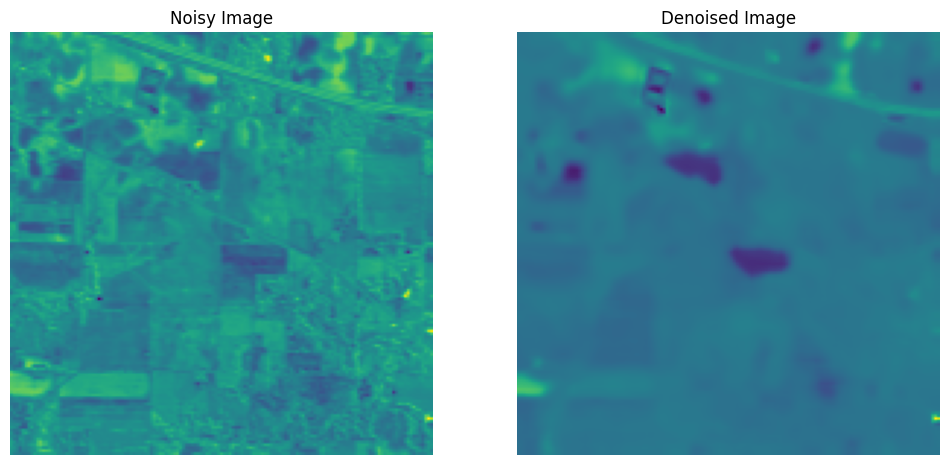

In [100]:
# Displayine a sample image : original vs noised
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(X[:, :, 1])
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
X[:, :, :]=denoised
plt.imshow(X[:, :, 1])
plt.title('Denoised Image')
plt.axis('off')

plt.show()


The image is actually clear as shown, and applying filters would likely degrade its quality further. Most filters are designed to enhance blurred images, which is not applicable to our dataset as it's already crystal clear. However, we tested it on our model to confirm our assumptions. The model took much longer than expected to converge, and we didn't let it finish since the preliminary results were catastrophic.

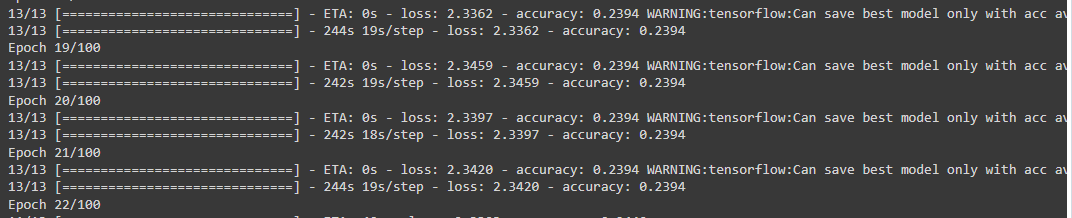

# Model and Training

***************************************************

****SVM****\
Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks. It's particularly effective in high-dimensional spaces and is widely used for classification tasks in various domains, including image recognition, text classification, and bioinformatics.

**Key Concepts:**\
1-Decision Boundary: In SVM, the goal is to find the optimal hyperplane that best separates the classes in the feature space. This hyperplane is called the decision boundary.\
2-Support Vectors: These are the data points that are closest to the decision boundary. They play a crucial role in defining the decision boundary.\
3-Margin: The margin is the distance between the decision boundary and the nearest data point from each class. SVM aims to maximize this margin, as it leads to better generalization and improves the model's ability to classify unseen data.

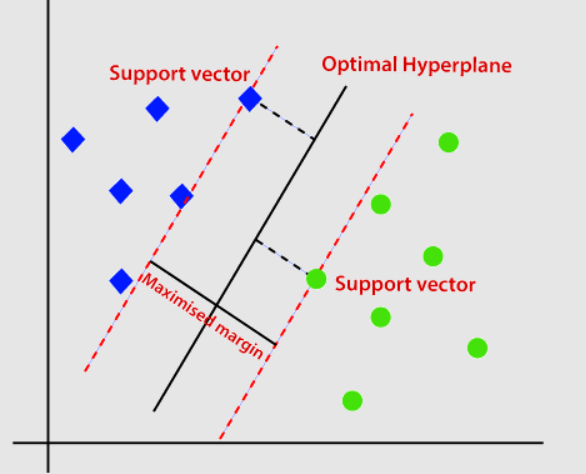

In [26]:
Xs = data_df.iloc[:, :-1].values
ys = data_df.iloc[:, -1].values
Xs.shape, ys.shape

((21025, 200), (21025,))

In [27]:
#kpca = KernelPCA(n_components = 50, kernel='poly', eigen_solver='arpack')
kpca = PCA(n_components=30, whiten=True) 
#pca = PCA(n_components=numComponents, svd_solver='arpack')
principalComponents = kpca.fit_transform(Xs)

principalComponents.shape

(21025, 30)

In [28]:
X_trainSVM, X_testSVM, y_trainSVM, y_testSVM, indices_train, indices_test  = train_test_split(principalComponents, ys,  range(Xs.shape[0]), 
                                                                                  test_size = 0.15, random_state = 11)

In [29]:
X_trainSVM.shape, X_testSVM.shape

((17871, 30), (3154, 30))

In [30]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', degree = 11, gamma='scale', cache_size=1024*7)
svm.fit(X_trainSVM, y_trainSVM)

SVC(cache_size=7168, degree=11)

**1- kernel:** This parameter specifies the type of kernel used in the SVM algorithm. The kernel function computes the inner product between two points in a higher-dimensional space, allowing the SVM to operate in that higher-dimensional space without explicitly calculating the coordinates of the data points. Common kernel types include:\
*'linear':* Linear kernel, which creates linear decision boundaries.\
*'rbf' (Radial Basis Function):* Gaussian kernel, which is commonly used and can handle non-linear decision boundaries.\
*'poly':* Polynomial kernel, which uses a polynomial function to create non-linear decision boundaries.\
*'sigmoid':* Sigmoid kernel, which uses a hyperbolic tangent function.\
**2- degree:** This parameter is specific to the polynomial kernel (kernel='poly'). It defines the degree of the polynomial kernel function. For example, if degree=3, the polynomial kernel function used is (1 + gamma ⋅ ⟨X ,X′⟩)3\
**3- gamma:** This parameter defines the kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels. Intuitively, a higher value of gamma defines how far the influence of a single training example reaches. It can be seen as the inverse of the radius of influence of samples selected by the model. Typical values for gamma are 'scale' (default), 'auto', or a float value.\
**4- cache_size:** This parameter specifies the size of the kernel cache in MB. The kernel cache is used to store the kernel matrix, which can speed up the training process. Larger values can lead to faster execution, but may also consume more memory. In the example, 1024*7 specifies a cache size of 7 GB.

In [31]:
y_predSVM = svm.predict(X_testSVM)

In [107]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f'Accuracy: {accuracy_score(y_testSVM, y_predSVM)*100}%')

Accuracy: 74.19150285351934%


In [32]:
# print(confusion_matrix(y_test,y_pred))
print('Classification report:\n',classification_report(y_testSVM,y_predSVM))

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83      1613
           1       0.00      0.00      0.00         8
           2       0.61      0.73      0.66       228
           3       0.72      0.29      0.42       116
           4       0.85      0.24      0.38        45
           5       0.96      0.62      0.75        74
           6       0.87      0.78      0.83       115
           7       1.00      0.25      0.40         4
           8       0.86      0.94      0.90        70
           9       0.00      0.00      0.00         2
          10       0.64      0.60      0.62       139
          11       0.64      0.79      0.71       336
          12       0.73      0.35      0.47       101
          13       0.86      0.86      0.86        36
          14       0.68      0.34      0.45       189
          15       0.00      0.00      0.00        57
          16       0.81      0.62      0.70        21

  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**Precision:** Precision measures the proportion of true positive predictions (correctly predicted instances of a class) among all instances classified as that class. In other words, it tells us how many of the instances predicted as belonging to a particular class actually belong to that class.\
**Precision= True Positives / True Positives+False Positives**\
**Recall:** Recall, also known as sensitivity, measures the proportion of true positive predictions among all actual instances of a class. It tells us how many of the actual instances of a class were correctly predicted by the model.\
**Recall= True Positives / True Positives+False Negatives**\
**F1-score:** The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. It is useful when the classes are imbalanced because it takes into account both false positives and false negatives.\
**F1 score= 2×(precision×recall) / precision+recall**\
**Support:** Support indicates the number of actual occurrences of each class in the test dataset.\
**Accuracy:** Accuracy measures the overall correctness of the model across all classes. It is the ratio of correctly predicted instances to the total number of instances.\
**Macro Avg:** The macro average calculates the average metric (precision, recall, or F1-score) across all classes without considering class imbalance. It gives equal weight to each class.\
**Weighted Avg:** The weighted average calculates the average metric across all classes, considering class imbalance by weighting each class's contribution by its support (number of true instances). It provides a more representative measure of overall model performance when classes are imbalanced.

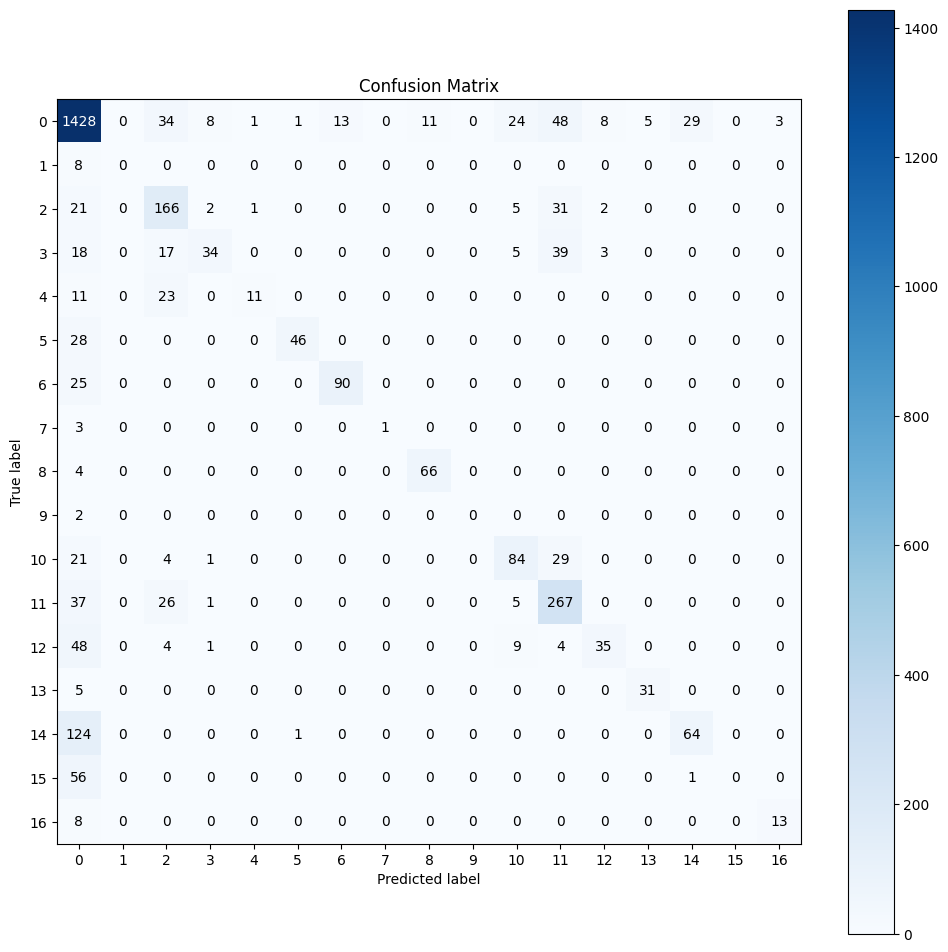

In [33]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_testSVM, 
    y_predSVM,
    figsize=(12,12));

In [34]:
from tqdm import tqdm

pre = y_predSVM

clmap = [0]*Xs.shape[0]

for i in tqdm(range(len(indices_train))):
    clmap[indices_train[i]] = ys[indices_train[i]]

for i in tqdm(range(len(indices_test))):
    clmap[indices_test[i]] = pre[i]

100%|██████████| 3154/3154 [00:00<00:00, 705462.61it/s]


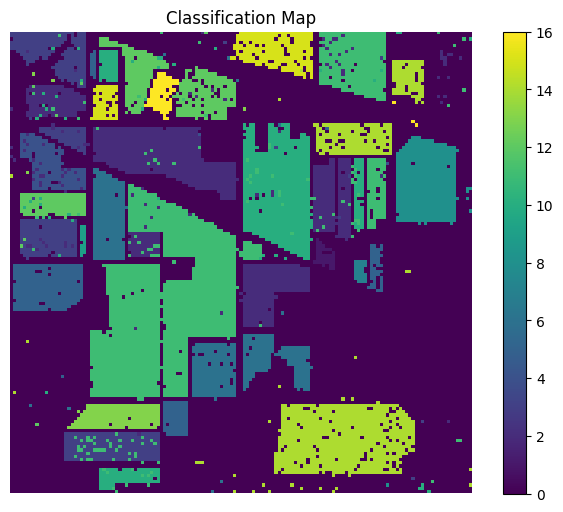

In [35]:
plt.figure(figsize=(8, 6))
plt.imshow(np.array(clmap).reshape((145, 145)))
plt.colorbar()
plt.axis('off')
plt.title('Classification Map')
plt.savefig('Classification_map.png')
plt.show()

**********************

**2D CNN**

In [27]:
#windowSize=25
x2d, y2d = createImageCubes(X, y, windowSize=5)
x2d.shape, y2d.shape

((10249, 5, 5, 30), (10249,))

In [28]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [29]:
x_train2d, x_test2d, y_train2d, y_test2d = splitTrainTestSet(x2d, y2d, test_ratio)

x_train2d.shape, x_test2d.shape, y_train2d.shape, y_test2d.shape

((3074, 5, 5, 30), (7175, 5, 5, 30), (3074,), (7175,))

In [30]:
# Reshape into (numberofsumples, channels, height, width)
x_train2d = np.reshape(x_train2d, (x_train2d.shape[0],x_train2d.shape[3], x_train2d.shape[1], x_train2d.shape[2]))

x_train2d.shape

(3074, 30, 5, 5)

In [31]:
from keras.utils import to_categorical

# convert class labels to one-hot encoding
y_train2d = to_categorical(y_train2d)

In [32]:
# Define the input shape 
input_shape= x_train2d[0].shape
print(input_shape)

(30, 5, 5)


In [33]:
# number of filters
numPCAcomponents=K
C1 = 3*numPCAcomponents

In [34]:
import numpy as np
import os
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model
model2d = Sequential()

model2d.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
model2d.add(Conv2D(3*C1, (3, 3), activation='relu'))
model2d.add(Dropout(0.25))



model2d.add(Flatten())
model2d.add(Dense(6*numPCAcomponents, activation='relu'))
model2d.add(Dropout(0.5))
model2d.add(Dense(16, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [35]:
from keras.optimizers import SGD

# Compile the model with categorical crossentropy loss
sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model2d.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [36]:
# Print model summary
print(model2d.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 3, 90)      │         4,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 1, 270)     │       218,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 1, 270)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7020)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 180)            │     1,263,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,489,786 (5.68 MB)

 Trainable params: 1,489,786 (5.68 MB)

 Non-trainable params: 0 (0.00 B)

None


In [37]:
# Train the model 
history2d=model2d.fit(x_train2d, y_train2d, batch_size=32, epochs=50)

Epoch 1/50


2024-05-05 12:10:45.171558: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8751: 7.78167, expected 8.77557
2024-05-05 12:10:45.171598: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8816: 7.77084, expected 8.76475
2024-05-05 12:10:45.172057: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 84404: 7.7202, expected 8.7141
2024-05-05 12:10:45.172182: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 97954: 7.8709, expected 8.86221
2024-05-05 12:10:45.172277: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 107051: 7.40463, expected 8.39853
2024-05-05 12:10:45.172493: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 134435: 7.53039, expected 8.50198
2024-05-05 12:10:45.172518: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 134686: 6.07541, expected 6.89774
2024-05-05 12:10:45.172544: E

66/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1029 - loss: 2.7243

I0000 00:00:1714911047.741291     217 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1081 - loss: 2.7160

2024-05-05 12:10:49.123141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6712: 8.63027, expected 7.64834
2024-05-05 12:10:49.123231: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10851: 8.44556, expected 7.48709
2024-05-05 12:10:49.123249: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10893: 8.3834, expected 7.42494
2024-05-05 12:10:49.123261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10913: 8.38351, expected 7.42504
2024-05-05 12:10:49.123271: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10916: 8.45926, expected 7.50079
2024-05-05 12:10:49.123304: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14199: 8.13418, expected 7.15225
2024-05-05 12:10:49.123314: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14278: 8.74887, expected 7.76694
2024-05-05 12:10:49.123341: E

97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.1111 - loss: 2.7119
Epoch 2/50
67/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2361 - loss: 2.5711

W0000 00:00:1714911050.997157     217 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2373 - loss: 2.5620
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2725 - loss: 2.4488
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2973 - loss: 2.3634
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3154 - loss: 2.2843
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3209 - loss: 2.2450
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3733 - loss: 2.1228
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3921 - loss: 2.0438
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4209 - loss: 1.9669
Epoch 10/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4417 - loss: 1.8736
Epoch 11/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4652 - loss: 1.8070
Epoch 12/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4724 - loss: 1.7563
Epoch 13/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5205 - loss: 1.6288

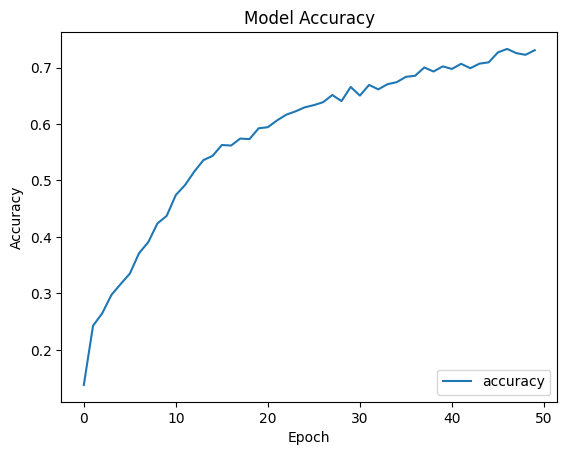

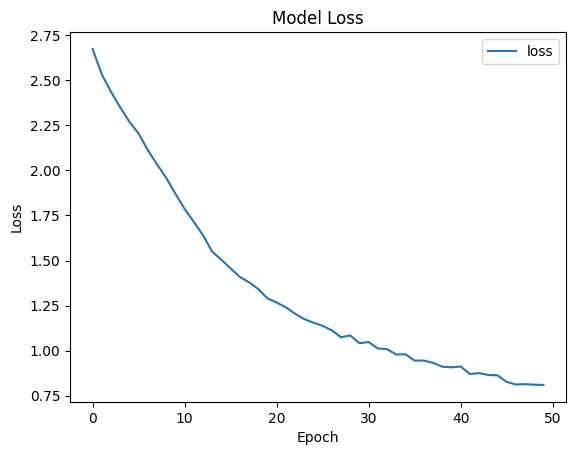

In [38]:
import matplotlib.pyplot as plt

# Plot training history: Accuracy
plt.plot(history2d.history['accuracy'], label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot training history: Loss
plt.plot(history2d.history['loss'], label='loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [39]:
from sklearn.metrics import classification_report

# Reshape x_test2d for prediction
x_test2d = np.reshape(x_test2d, (x_test2d.shape[0], x_test2d.shape[3], x_test2d.shape[1], x_test2d.shape[2]))

# Perform predictions
y_pred2d = model2d.predict(x_test2d)

# Convert predictions from one-hot encoding to class labels
y_pred2d_labels = np.argmax(y_pred2d, axis=1)

# Print classification report
print(classification_report(y_test2d, y_pred2d_labels))


196/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2024-05-05 12:11:12.212137: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11775: 8.18937, expected 7.24643
2024-05-05 12:11:12.212223: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15702: 7.60726, expected 6.72558
2024-05-05 12:11:12.212348: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30820: 7.47134, expected 6.58966
2024-05-05 12:11:12.212402: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 34505: 8.3553, expected 7.41236
2024-05-05 12:11:12.212419: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 34515: 8.39435, expected 7.45141
2024-05-05 12:11:12.212434: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 34516: 8.14277, expected 7.19983
2024-05-05 12:11:12.212581: E external/local_xla/xla/service/gpu/conv_algorithm_picker.cc:705] Results mismatch between different convolution algorithms. This is likel

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        32
         1.0       0.61      0.64      0.62      1000
         2.0       0.77      0.48      0.59       581
         3.0       0.92      0.22      0.35       166
         4.0       0.96      0.87      0.91       338
         5.0       0.92      0.99      0.96       511
         6.0       0.00      0.00      0.00        20
         7.0       0.87      1.00      0.93       335
         8.0       0.00      0.00      0.00        14
         9.0       0.60      0.56      0.57       680
        10.0       0.64      0.87      0.74      1719
        11.0       0.73      0.24      0.37       415
        12.0       0.99      0.99      0.99       143
        13.0       0.90      0.98      0.94       886
        14.0       0.89      0.63      0.74       270
        15.0       0.97      0.97      0.97        65

    accuracy                           

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [29]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 5
numComponents = 30

In [30]:
def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [31]:
model2d.input_shape

(None, 30, 5, 5)

In [32]:
# Calculate the predicted image
outputs = np.zeros((height, width))
for i in range(height - PATCH_SIZE + 1):
    for j in range(width - PATCH_SIZE + 1):
        a = i + PATCH_SIZE // 2
        b = j + PATCH_SIZE // 2
        target = int(y[a, b])
        if target == 0:
            continue
        else:
            input_shape = model2d.input_shape
            image_patch = Patch(X, i, j)
            X_test_image = image_patch.reshape(1, PATCH_SIZE, PATCH_SIZE, X.shape[2]).astype('float32')
            X_test_image = X_test_image.reshape((1,) + input_shape[1:])  # Ensure correct reshaping
            prediction = model2d.predict(X_test_image,verbose=False)
            predicted_class = np.argmax(prediction) + 1
            outputs[a][b] = predicted_class
print("done")

2024-05-05 11:36:43.088704: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1860: 7.43027, expected 6.57493
2024-05-05 11:36:43.088757: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1863: 7.46263, expected 6.60729
2024-05-05 11:36:43.088767: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1866: 7.23914, expected 6.3838
2024-05-05 11:36:43.088775: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1870: 7.44176, expected 6.58641
2024-05-05 11:36:43.088783: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1877: 7.49373, expected 6.63838
2024-05-05 11:36:43.088791: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1880: 6.93701, expected 6.08167
2024-05-05 11:36:43.088798: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1882: 7.0152, expected 6.15985
2024-05-05 11:36:43.088806: E extern

done


/opt/conda/lib/python3.10/site-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



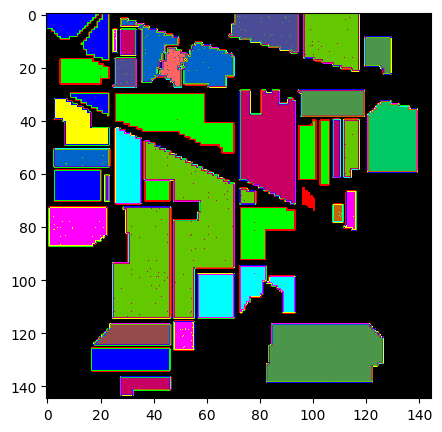

In [126]:
ground_truth = spectral.imshow(classes = y,figsize =(5,5))

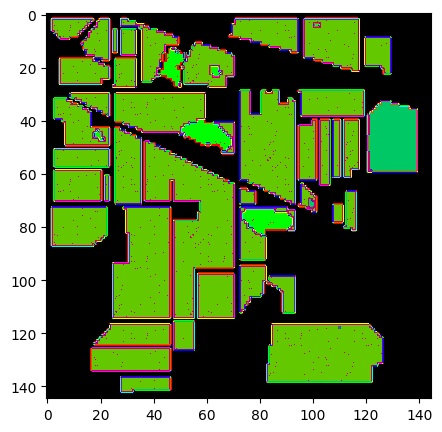

In [127]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

As we can see the 2D CNN model is suffering from underfitting, it almost predicts O correct classes!

********************************************************************

**Hybrid SN**

**Hybrid Spectral-Spatial Convolutional Neural Network (HybridSN)** for Hyperspectral Image Classification
The HybridSN model is a deep learning architecture designed for hyperspectral image classification. It leverages the strengths of both 3D and 2D convolutional neural networks (CNNs) to capture both spectral and spatial features from hyperspectral data.

Here's a breakdown of the HybridSN model:

**1. 3D Spectral Convolutional Layer:**\
This layer processes the input hyperspectral image, which typically has a 3D structure with dimensions of (height, width, channels).
The channels represent different spectral bands capturing information at various wavelengths.
The 3D convolution filters learn to extract spatial and spectral features jointly.

**2. Spatial Pooling:**\
A pooling layer like MaxPooling is often used after the 3D convolution to reduce the dimensionality and introduce some level of invariance to small spatial shifts.

**3. 2D Spatial Convolutional Layers:**\
One or more 2D convolutional layers are stacked on top of the processed feature maps from the 3D layer.
These layers focus on extracting more complex spatial features from the data.

**4. Flatten Layer:**\
The output from the final 2D convolutional layer is flattened into a 1D vector.

**5. Dense Layers:**
One or more fully connected (dense) layers are used to learn higher-level features and perform classification.
The final dense layer typically has a softmax activation function to predict the probability distribution over the different classes.
Benefits of HybridSN:

**Joint Feature Extraction:** Captures both spectral and spatial information simultaneously through 3D convolutions.

**Improved Classification Performance:** Can achieve better accuracy compared to models relying solely on 2D convolutions.

**Reduced Model Complexity:** Utilizes 2D convolutions in later stages for efficiency compared to using only 3D convolutions throughout.

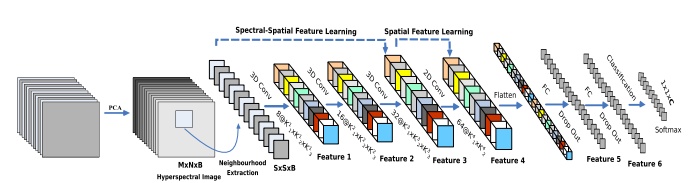

In [128]:
X, y = loadData()

X.shape, y.shape

((145, 145, 200), (145, 145))

In [129]:
K = 30
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [130]:
#windowSize=25
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

we used 25 as a windowSize for many reasons:\
1-Spatial Context: A window size of 25x25 provides a reasonable amount of spatial context around each pixel, which is crucial for tasks like classification or segmentation.\
2-Computational Complexity: A window size of 25 balances capturing sufficient context with manageable computational costs, especially for convolutional operations.\
3-Information Content: This window size allows for extracting meaningful spectral information from neighboring pixels while avoiding redundancy.\
4-Empirical Performance: Previous studies and experiments have shown that a window size of 25 often yields satisfactory results for hyperspectral imaging tasks such as classification and feature extraction.\
Ultimately, the choice of window size depends on factors such as the dataset's characteristics, computational resources, and specific analysis objectives, and a window size of 25 is a common and practical choice for processing hyperspectral images.








In [131]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [132]:
XtrainSN, XtestSN, ytrainSN, ytestSN = splitTrainTestSet(X, y, test_ratio)

XtrainSN.shape, XtestSN.shape, ytrainSN.shape, ytestSN.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

In [133]:
XtrainSN = XtrainSN.reshape(-1, windowSize, windowSize, K, 1)
XtrainSN.shape

(3074, 25, 25, 30, 1)

In [134]:
from tensorflow.keras.utils import to_categorical

ytrainSN = to_categorical(ytrainSN)
ytrainSN.shape


(3074, 16)

In [135]:
S = windowSize
L = K
output_units = 16

In [136]:
## input layer
input_layerSN = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layerSN)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layerSN = Dense(units=output_units, activation='softmax')(dense_layer2)

In [137]:
# define the model with input layer and output layer
modelSN = Model(inputs=input_layerSN, outputs=output_layerSN)

In [138]:
modelSN.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 25, 25, 30, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 23, 23, 24, 8)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 21, 21, 20, 16) │         5,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 19, 19, 18, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 19, 576)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 64)     │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,122,176 (19.54 MB)

 Trainable params: 5,122,176 (19.54 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [140]:
# compiling the model
#adam = Adam(learning_rate=0.001, decay=1e-06)
modelSN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [141]:
# checkpoint
filepath = "best-model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [142]:
history = modelSN.fit(x=XtrainSN, y=ytrainSN, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100


2024-05-05 10:38:24.950468: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,16,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[256,16,21,21,20]{4,3,2,1,0}, f32[256,32,19,19,18]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-05 10:38:25.282540: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.332253655s
Trying algorithm eng0{} for conv (f32[32,16,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[256,16,21,21,20]{4,3,2,1,0}, f32[256,32,19,19,18]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-05 10:38:27.124231: E

 1/13 ━━━━━━━━━━━━━━━━━━━━ 4:36 23s/step - accuracy: 0.0469 - loss: 2.8055

W0000 00:00:1714905512.226634     195 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 504ms/step - accuracy: 0.1171 - loss: 2.7208
Epoch 2/100
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.2148 - loss: 2.4723

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning:

Can save best model only with acc available, skipping.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.2113 - loss: 2.4768
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2400 - loss: 2.3367
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.3007 - loss: 1.9805
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.4051 - loss: 1.6173
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.4886 - loss: 1.3905
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5827 - loss: 1.2323
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6493 - loss: 1.0427
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.7350 - loss: 0.8040
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8010 - loss: 0.6124
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8652 - loss: 0.4223
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9166 - loss: 0.2650
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/ste

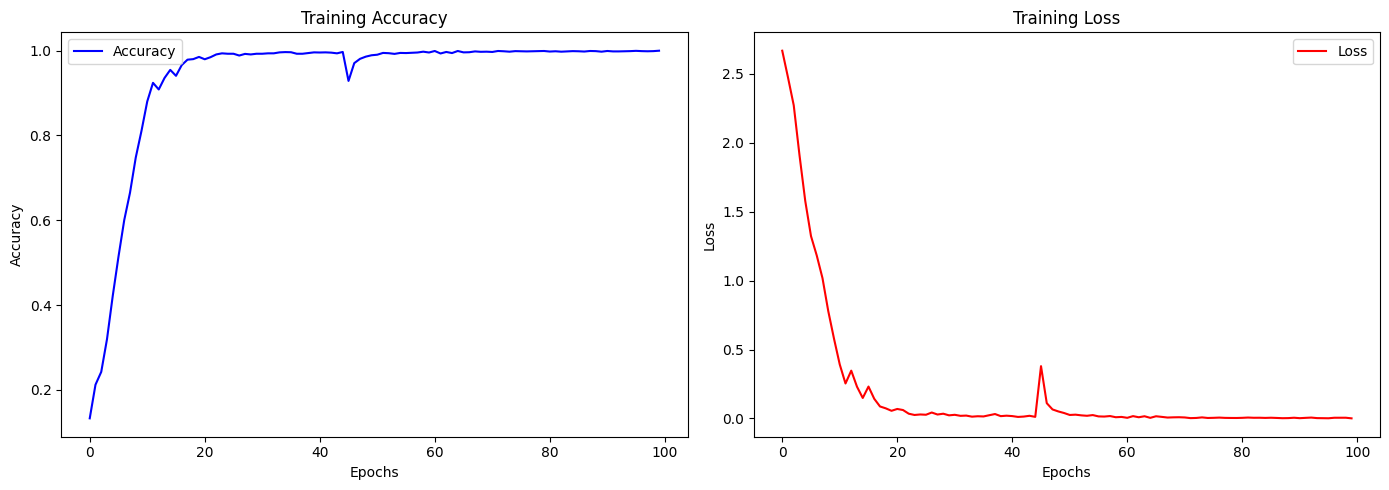

In [167]:
import matplotlib.pyplot as plt

# Get training history
accuracy = history.history['accuracy']
loss = history.history['loss']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(accuracy, label='Accuracy', color='blue')
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot loss
axes[1].plot(loss, label='Loss', color='red')
axes[1].set_title('Training Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


In [143]:
modelSN.save("best-model.keras")

# Validation

In [144]:
# load best weights
modelSN.load_weights("best-model.keras")
modelSN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [147]:
X_testSN = XtestSN.reshape(-1, windowSize, windowSize, K, 1)
X_testSN.shape

(7175, 25, 25, 30, 1)

In [148]:
y_testSN = to_categorical(ytestSN)
y_testSN.shape

(7175, 16)

In [149]:
Y_pred_test = modelSN.predict(X_testSN)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(y_testSN, axis=1), y_pred_test)
print(classification)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      0.99      1.00      1000
           2       0.99      1.00      1.00       581
           3       0.99      0.99      0.99       166
           4       0.98      1.00      0.99       338
           5       0.98      1.00      0.99       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       1.00      1.00      1.00        14
           9       1.00      0.99      1.00       680
          10       1.00      0.99      1.00      1719
          11       0.99      0.99      0.99       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       1.00      0.99      0.99       270
          15       1.00      0.98      0.99        65

    accuracy                           

In [150]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [155]:
def reports (X_test,y_test):
    #start = time.time()
    Y_pred = modelSN.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                    ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                    'Stone-Steel-Towers']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = modelSN.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [156]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_testSN,y_testSN)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9967 - loss: 0.0279


In [158]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [160]:
# load the original image
X, y = loadData()

In [161]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [162]:
X,pca = applyPCA(X, numComponents=numComponents)

In [163]:
X = padWithZeros(X, PATCH_SIZE//2)

In [164]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (modelSN.predict(X_test_image,verbose=False))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1
print("done")   

/tmp/ipykernel_34/2406152380.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



done


/opt/conda/lib/python3.10/site-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



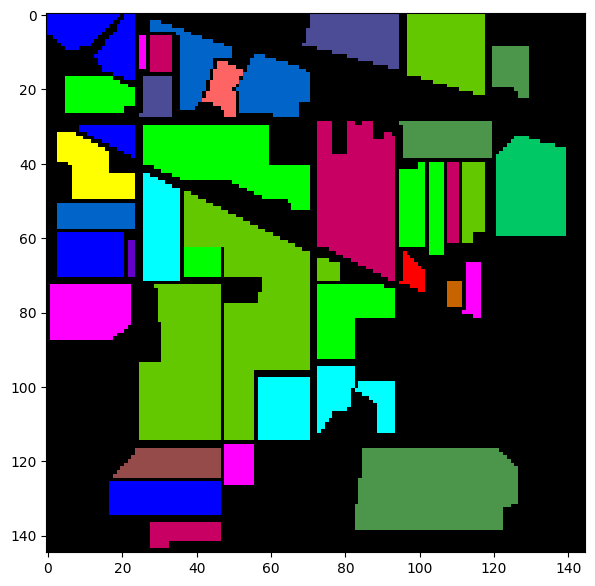

In [165]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

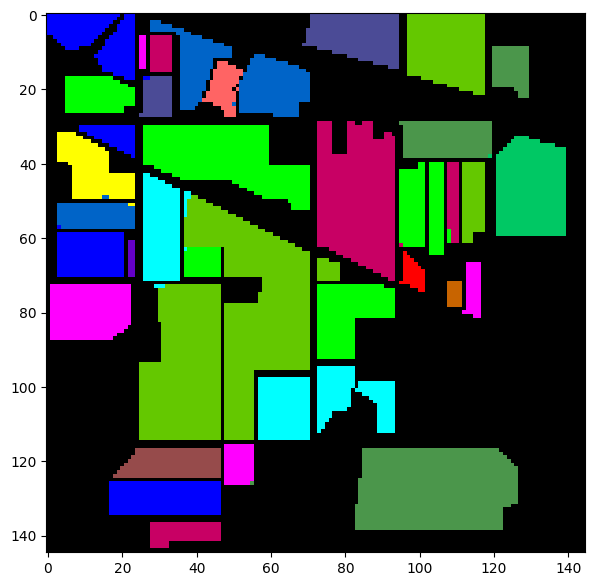

In [166]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)